In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
#file_path = '/content/drive/MyDrive/DM project/Walmart.csv'
#df = pd.read_csv(file_path)

In [3]:
try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True
except ImportError:
    !pip install plotly -q
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True

try:
    from google.colab import drive
    drive.mount('/content/drive')
    COLAB_ENV = True
    file_path = '/content/drive/MyDrive/DM project/Walmart.csv'
except:
    COLAB_ENV = False
    file_path = 'Walmart.csv'

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:,.2f}'.format)

COLORS = {
    'critical': '#DC3545',
    'warning': '#FFC107',
    'success': '#28A745',
    'primary': '#007BFF',
    'secondary': '#6C757D',
    'dark': '#343A40',
    'domestic': '#4E79A7',
    'international': '#F28E2B'
}


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Data Preprocessing



In [4]:
df_raw = pd.read_csv(file_path)
print(f"\nRaw data loaded: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")


Raw data loaded: 5,000 rows × 28 columns


In [5]:
ORIGINAL_ROWS = df_raw.shape[0]

In [6]:
duplicates = df_raw.duplicated().sum()
print(f"Duplicate rows found: {duplicates:,}")

Duplicate rows found: 0


In [7]:
missing_summary = df_raw.isnull().sum()
missing_cols = missing_summary[missing_summary > 0]
if len(missing_cols) > 0:
    print(f"Columns with missing values:")
    for col, count in missing_cols.items():
        print(f"       • {col}: {count:,} ({count/len(df_raw)*100:.2f}%)")
else:
    print("No missing values detected")

Columns with missing values:
       • promotion_type: 3,407 (68.14%)


In [8]:
df = df_raw.copy()

In [9]:
df = df.drop_duplicates()
rows_after_dedup = df.shape[0]
print(f"\n After deduplication: {rows_after_dedup:,} rows")


 After deduplication: 5,000 rows


In [10]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'], format='mixed')
df['transaction_month'] = df['transaction_date'].dt.to_period('M')
df['transaction_week'] = df['transaction_date'].dt.isocalendar().week
df['transaction_hour'] = df['transaction_date'].dt.hour

In [11]:
impossible_conditions = {
    'Negative Inventory': df['inventory_level'] < 0,
    'Negative Price': df['unit_price'] <= 0,
    'Negative Demand': df['actual_demand'] < 0,
    'Negative Forecast': df['forecasted_demand'] < 0,
    'Invalid Lead Time': df['supplier_lead_time'] < 0,
    'Zero Quantity Sold': df['quantity_sold'] <= 0
}

In [12]:
total_impossible = 0
for condition_name, condition in impossible_conditions.items():
    count = condition.sum()
    if count > 0:
        print(f"{condition_name}: {count:,} rows flagged")
        total_impossible += count

In [13]:
valid_mask = ~(
    (df['inventory_level'] < 0) |
    (df['unit_price'] <= 0) |
    (df['actual_demand'] < 0) |
    (df['forecasted_demand'] < 0) |
    (df['supplier_lead_time'] < 0) |
    (df['quantity_sold'] <= 0)
)

df = df[valid_mask].copy()
print(f"\nAfter domain validation: {df.shape[0]:,} rows")


After domain validation: 5,000 rows


In [14]:
df = df.sort_values('transaction_date')

In [15]:
weather_missing_before = df['weather_conditions'].isnull().sum()
df['weather_conditions'] = df['weather_conditions'].ffill()
df['weather_conditions'] = df['weather_conditions'].bfill()  # Backup for first rows
weather_missing_after = df['weather_conditions'].isnull().sum()

print(f"Missing weather before: {weather_missing_before:,}")
print(f"Missing weather after: {weather_missing_after:,}")
print("Weather imputation: Forward Fill Applied")

Missing weather before: 0
Missing weather after: 0
Weather imputation: Forward Fill Applied


In [16]:
regional_lead_times = df.groupby('store_location')['supplier_lead_time'].median()
print("Regional median lead times:")
for loc, lt in regional_lead_times.items():
    print(f"{loc}: {lt:.1f} days")

Regional median lead times:
Chicago, IL: 6.0 days
Dallas, TX: 6.0 days
Los Angeles, CA: 6.0 days
Miami, FL: 6.0 days
New York, NY: 6.0 days


In [17]:
lead_time_missing = df['supplier_lead_time'].isnull().sum()
if lead_time_missing > 0:
    df['supplier_lead_time'] = df.groupby('store_location')['supplier_lead_time'].transform(
        lambda x: x.fillna(x.median())
    )
    df['supplier_lead_time'] = df['supplier_lead_time'].fillna(df['supplier_lead_time'].median())

In [79]:
def cap_outliers_iqr(series, multiplier=3.0):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - multiplier * IQR
    upper = Q3 + multiplier * IQR
    capped = series.clip(lower=max(0, lower), upper=upper)
    outliers_capped = ((series < lower) | (series > upper)).sum()
    return capped, outliers_capped

outlier_cols = ['unit_price', 'actual_demand', 'forecasted_demand', 'customer_income']
for col in outlier_cols:
    df[col], n_capped = cap_outliers_iqr(df[col])
    if n_capped > 0:
        print(f"   • {col}: {n_capped:,} outliers capped")

In [19]:
categorical_cols = ['store_location', 'category', 'product_name', 'weather_conditions',
                    'customer_gender', 'customer_loyalty_level', 'payment_method',
                    'promotion_type', 'weekday']

for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

bool_cols = ['promotion_applied', 'holiday_indicator', 'stockout_indicator']
for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].astype(bool)

In [20]:
memory_before = df_raw.memory_usage(deep=True).sum() / 1024**2
memory_after = df.memory_usage(deep=True).sum() / 1024**2
print(f"   • Memory before: {memory_before:.2f} MB")
print(f"   • Memory after: {memory_after:.2f} MB")
print(f"   • Reduction: {(1 - memory_after/memory_before)*100:.1f}%")

   • Memory before: 3.25 MB
   • Memory after: 0.79 MB
   • Reduction: 75.7%


In [21]:
FINAL_ROWS = df.shape[0]
rows_removed = ORIGINAL_ROWS - FINAL_ROWS

In [22]:
print(f"original rows:     {ORIGINAL_ROWS:,}")
print(f"sanitized rows:    {FINAL_ROWS:,}")
print(f"rows removed:      {rows_removed:,} ({rows_removed/ORIGINAL_ROWS*100:.2f}%)")

original rows:     5,000
sanitized rows:    5,000
rows removed:      0 (0.00%)


### 1. Global feature engineering

####1.1 Reginal segmentation

1. Since all data is US-based, we create meaningful operational segments
2. Coastal cities = higher logistics complexity (ports, international shipping)
3. Inland cities = more domestic supply chain focused



In [23]:
def classify_region(location):
    coastal_cities = ['Miami, FL', 'Los Angeles, CA', 'New York, NY']
    if location in coastal_cities:
        return 'Coastal/High-Complexity'
    else:
        return 'Inland/Standard'

In [24]:
def classify_weather_zone(location):
    hurricane_zone = ['Miami, FL']
    winter_zone = ['Chicago, IL', 'New York, NY']
    moderate_zone = ['Los Angeles, CA', 'Dallas, TX']

    if location in hurricane_zone:
        return 'Hurricane Risk Zone'
    elif location in winter_zone:
        return 'Winter Storm Zone'
    else:
        return 'Moderate Zone'

In [25]:
df['operational_region'] = df['store_location'].apply(classify_region)
df['weather_zone'] = df['store_location'].apply(classify_weather_zone)

In [26]:
df['is_high_complexity'] = (df['operational_region'] == 'Coastal/High-Complexity').astype(int)

print("\nOperational region distribution:")
region_dist = df['operational_region'].value_counts()
for region, count in region_dist.items():
    print(f"{region}: {count:,} transactions ({count/len(df)*100:.1f}%)")


Operational region distribution:
Coastal/High-Complexity: 2,989 transactions (59.8%)
Inland/Standard: 2,011 transactions (40.2%)


In [27]:
print("\nWeather zone distribution:")
weather_zone_dist = df['weather_zone'].value_counts()
for zone, count in weather_zone_dist.items():
    print(f"{zone}: {count:,} transactions ({count/len(df)*100:.1f}%)")


Weather zone distribution:
Moderate Zone: 2,036 transactions (40.7%)
Winter Storm Zone: 2,000 transactions (40.0%)
Hurricane Risk Zone: 964 transactions (19.3%)


####1.2 Demand gap analysis


In [28]:
df['demand_gap'] = df['actual_demand'] - df['forecasted_demand']
df['demand_gap_pct'] = (df['demand_gap'] / df['forecasted_demand'].replace(0, np.nan)) * 100
df['demand_ratio'] = df['actual_demand'] / df['forecasted_demand'].replace(0, np.nan)

In [29]:
def classify_demand_deviation(ratio):
    """Classify demand deviation severity"""
    if pd.isna(ratio):
        return 'Unknown'
    elif ratio > 2.0:
        return 'Severe Underforecast (>2x)'
    elif ratio > 1.5:
        return 'Significant Underforecast'
    elif ratio > 1.2:
        return 'Mild Underforecast'
    elif ratio >= 0.8:
        return 'Within Tolerance'
    elif ratio >= 0.5:
        return 'Overforecast'
    else:
        return 'Severe Overforecast (<0.5x)'

df['demand_deviation_class'] = df['demand_ratio'].apply(classify_demand_deviation)

print("\nDemand deviation distribution:")
deviation_dist = df['demand_deviation_class'].value_counts()
for dev_class, count in deviation_dist.items():
    print(f"{dev_class}: {count:,} ({count/len(df)*100:.1f}%)")


Demand deviation distribution:
Within Tolerance: 1,281 (25.6%)
Overforecast: 1,007 (20.1%)
Severe Overforecast (<0.5x): 764 (15.3%)
Severe Underforecast (>2x): 737 (14.7%)
Mild Underforecast: 634 (12.7%)
Significant Underforecast: 577 (11.5%)


####1.3 Stockout risk indications

In [30]:
df['stockout_risk'] = df['inventory_level'] < df['reorder_point']

# Days of inventory remaining (based on recent demand)
df['days_of_inventory'] = df['inventory_level'] / df['actual_demand'].replace(0, np.nan)
df['days_of_inventory'] = df['days_of_inventory'].clip(upper=365)  # Cap at 1 year

# Critical stockout (inventory < 50% of reorder point)
df['critical_stockout'] = df['inventory_level'] < (df['reorder_point'] * 0.5)

# Lead time coverage (can we survive the lead time?)
df['lead_time_buffer'] = df['days_of_inventory'] - df['supplier_lead_time']
df['can_survive_lead_time'] = df['lead_time_buffer'] > 0

stockout_risk_count = df['stockout_risk'].sum()
critical_stockout_count = df['critical_stockout'].sum()

print(f"\nStockout risk transactions: {stockout_risk_count:,} ({stockout_risk_count/len(df)*100:.1f}%)")
print(f"Critical stockout transactions: {critical_stockout_count:,} ({critical_stockout_count/len(df)*100:.1f}%)")
print(f"Healthy inventory transactions: {len(df) - stockout_risk_count:,}")


Stockout risk transactions: 938 (18.8%)
Critical stockout transactions: 466 (9.3%)
Healthy inventory transactions: 4,062


####1.4 Demand volatility (rolling statistics)

In [31]:
df['store_category'] = df['store_location'].astype(str) + ' | ' + df['category'].astype(str)

In [32]:
volatility_stats = df.groupby('store_category').agg({
    'actual_demand': ['mean', 'std', 'count']
}).reset_index()
volatility_stats.columns = ['store_category', 'mean_demand', 'std_demand', 'transaction_count']
volatility_stats['coefficient_of_variation'] = volatility_stats['std_demand'] / volatility_stats['mean_demand']

In [33]:
df = df.merge(
    volatility_stats[['store_category', 'coefficient_of_variation']],
    on='store_category',
    how='left'
)

In [34]:
df['volatility_class'] = pd.cut(
    df['coefficient_of_variation'],
    bins=[0, 0.3, 0.6, 1.0, np.inf],
    labels=['Low Volatility', 'Moderate Volatility', 'High Volatility', 'Extreme Volatility']
)


In [35]:
print("\nVolatility distribution:")
vol_dist = df['volatility_class'].value_counts()
for vol_class, count in vol_dist.items():
    print(f"{vol_class}: {count:,} ({count/len(df)*100:.1f}%)")


Volatility distribution:
Moderate Volatility: 5,000 (100.0%)
Low Volatility: 0 (0.0%)
High Volatility: 0 (0.0%)
Extreme Volatility: 0 (0.0%)


####1.5 Promotional and seasonal features

In [36]:
df['promo_demand_lift'] = np.where(
    df['promotion_applied'] == True,
    df['actual_demand'] / df['forecasted_demand'].replace(0, np.nan),
    np.nan
)

In [37]:
df['is_weekend'] = df['weekday'].isin(['Saturday', 'Sunday'])

In [38]:
df['is_peak_hour'] = df['transaction_hour'].between(10, 20)

In [39]:
income_75th = df['customer_income'].quantile(0.75)
df['is_high_income_customer'] = df['customer_income'] > income_75th

In [40]:
price_75th = df['unit_price'].quantile(0.75)
df['is_premium_product'] = df['unit_price'] > price_75th

print(f"Weekend transactions: {df['is_weekend'].sum():,}")
print(f"Peak hour transactions: {df['is_peak_hour'].sum():,}")
print(f"High-income customer transactions: {df['is_high_income_customer'].sum():,}")
print(f"Premium product transactions: {df['is_premium_product'].sum():,}")


Weekend transactions: 1,370
Peak hour transactions: 2,251
High-income customer transactions: 1,250
Premium product transactions: 1,250


####1.6 Feature engineering summary

In [41]:
new_features = [
    'operational_region', 'weather_zone', 'is_high_complexity',
    'demand_gap', 'demand_gap_pct', 'demand_ratio', 'demand_deviation_class',
    'stockout_risk', 'days_of_inventory', 'critical_stockout',
    'lead_time_buffer', 'can_survive_lead_time',
    'coefficient_of_variation', 'volatility_class',
    'is_weekend', 'is_peak_hour', 'is_high_income_customer', 'is_premium_product'
]

print(f"\n{len(new_features)} new features engineered:")
for i, feat in enumerate(new_features, 1):
    print(f"{i:2d}. {feat}")

print(f"\nFinal dataFrame shape: {df.shape[0]:,} rows × {df.shape[1]} columns")



18 new features engineered:
 1. operational_region
 2. weather_zone
 3. is_high_complexity
 4. demand_gap
 5. demand_gap_pct
 6. demand_ratio
 7. demand_deviation_class
 8. stockout_risk
 9. days_of_inventory
10. critical_stockout
11. lead_time_buffer
12. can_survive_lead_time
13. coefficient_of_variation
14. volatility_class
15. is_weekend
16. is_peak_hour
17. is_high_income_customer
18. is_premium_product

Final dataFrame shape: 5,000 rows × 51 columns


### 2. Anamaly & financial detection

####2.1 Statistical anomaly detection & finantial risk quantification

In [42]:
df['demand_zscore'] = df.groupby('category')['actual_demand'].transform(
    lambda x: (x - x.mean()) / x.std()
)

In [43]:
DEMAND_SHOCK_THRESHOLD = 2.0
DEMAND_CRASH_THRESHOLD = -2.0

In [44]:
# flag anomalies
df['is_demand_shock'] = df['demand_zscore'] > DEMAND_SHOCK_THRESHOLD
df['is_demand_crash'] = df['demand_zscore'] < DEMAND_CRASH_THRESHOLD
df['is_demand_anomaly'] = df['is_demand_shock'] | df['is_demand_crash']

demand_shock_count = df['is_demand_shock'].sum()
demand_crash_count = df['is_demand_crash'].sum()

print(f"\nDemand shocks detected (>+2σ): {demand_shock_count:,}")
print(f"Demand crashes detected (<-2σ): {demand_crash_count:,}")
print(f"Total demand anomalies: {demand_shock_count + demand_crash_count:,}")


Demand shocks detected (>+2σ): 0
Demand crashes detected (<-2σ): 0
Total demand anomalies: 0


#### 2.2 Weather-correlated anomaly detection

In [45]:
adverse_weather = ['Stormy', 'Rainy']

In [46]:
df['is_weather_shock'] = (
    (df['demand_ratio'] > 1.5) &  # Actual > 1.5x Forecast
    (df['weather_conditions'].isin(adverse_weather))
)

In [47]:
df['is_weather_crash'] = (
    (df['demand_ratio'] < 0.7) &  # Actual < 70% of Forecast
    (df['weather_conditions'].isin(adverse_weather))
)

In [48]:
weather_shock_count = df['is_weather_shock'].sum()
weather_crash_count = df['is_weather_crash'].sum()

print(f"\nWeather-correlated demand shocks: {weather_shock_count:,}")
print(f"(High demand during stormy/rainy conditions)")
print(f"Weather-correlated demand crashes: {weather_crash_count:,}")
print(f"(Low demand during stormy/rainy conditions)")


Weather-correlated demand shocks: 652
(High demand during stormy/rainy conditions)
Weather-correlated demand crashes: 679
(Low demand during stormy/rainy conditions)


In [49]:
df['has_weather_impact'] = df['is_weather_shock'] | df['is_weather_crash']

#### 2.3 Forecast model blind spot analysis

In [50]:
forecast_performance = df.groupby(['category', 'weather_conditions']).agg({
    'demand_gap': 'mean',
    'demand_gap_pct': 'mean',
    'is_demand_shock': 'mean',
    'transaction_id': 'count'
}).reset_index()
forecast_performance.columns = ['Category', 'Weather', 'Avg_Gap', 'Avg_Gap_Pct',
                                'Shock_Rate', 'Transaction_Count']

In [51]:
blind_spots = forecast_performance[forecast_performance['Avg_Gap'] > 50].sort_values(
    'Avg_Gap', ascending=False
)


In [52]:
print("\nTop forcast blind spots (Avg underforecast > 50 units):")
if len(blind_spots) > 0:
    for _, row in blind_spots.head(5).iterrows():
        print(f"{row['Category']} + {row['Weather']}: "
              f"Avg gap = +{row['Avg_Gap']:.0f} units ({row['Avg_Gap_Pct']:.1f}%)")
else:
    print("No major systematic blind spots detected")




Top forcast blind spots (Avg underforecast > 50 units):
No major systematic blind spots detected


####2.4 Revenue at risk calculation

In [53]:
df['unmet_demand'] = np.where(
    df['stockout_indicator'] == True,
    np.maximum(df['actual_demand'] - df['inventory_level'], 0),
    0
)

df['revenue_at_risk'] = df['unmet_demand'] * df['unit_price']

In [54]:
df['potential_revenue_at_risk'] = np.where(
    df['stockout_risk'] == True,
    df['actual_demand'] * df['unit_price'],
    0
)

In [80]:
total_revenue_at_risk = df['revenue_at_risk'].sum()
total_potential_risk = df['potential_revenue_at_risk'].sum()
stockout_transactions = df['stockout_indicator'].sum()
at_risk_transactions = df['stockout_risk'].sum()

print(f"""
   Finantial risk summary
   ═══════════════════════════════════════

   Actual stockouts:
   • Stockout transactions: {stockout_transactions:,}
   • Realized revenue loss: ${total_revenue_at_risk:,.2f}
   • Avg loss per stockout: ${total_revenue_at_risk/max(stockout_transactions,1):,.2f}

   Projected risk (inventory below reorder point):
   • At-risk transactions: {at_risk_transactions:,}
   • Potential revenue exposure: ${total_potential_risk:,.2f}
""")


   Finantial risk summary
   ═══════════════════════════════════════

   Actual stockouts:
   • Stockout transactions: 2,593
   • Realized revenue loss: $281,892,047.03
   • Avg loss per stockout: $108,712.71

   Projected risk (inventory below reorder point):
   • At-risk transactions: 938
   • Potential revenue exposure: $299,775,633.94



####2.5 Revenue at risk by segment

In [56]:
# by store location
risk_by_location = df.groupby('store_location').agg({
    'revenue_at_risk': 'sum',
    'stockout_indicator': 'sum',
    'transaction_id': 'count'
}).reset_index()
risk_by_location.columns = ['Location', 'Revenue_At_Risk', 'Stockouts', 'Transactions']
risk_by_location['Stockout_Rate'] = risk_by_location['Stockouts'] / risk_by_location['Transactions'] * 100
risk_by_location = risk_by_location.sort_values('Revenue_At_Risk', ascending=False)

print("\nRevenue at risk by location:")
for _, row in risk_by_location.iterrows():
    print(f"{row['Location']}: ${row['Revenue_At_Risk']:,.0f} "
          f"({row['Stockouts']:,} stockouts, {row['Stockout_Rate']:.1f}% rate)")


Revenue at risk by location:
Miami, FL: $61,822,555 (489 stockouts, 50.7% rate)
Chicago, IL: $57,394,330 (519 stockouts, 51.2% rate)
Los Angeles, CA: $55,678,019 (542 stockouts, 52.2% rate)
New York, NY: $54,439,038 (547 stockouts, 55.4% rate)
Dallas, TX: $52,558,104 (496 stockouts, 49.7% rate)


In [57]:
#by category
risk_by_category = df.groupby('category').agg({
    'revenue_at_risk': 'sum',
    'stockout_indicator': 'sum'
}).reset_index()
risk_by_category.columns = ['Category', 'Revenue_At_Risk', 'Stockouts']
risk_by_category = risk_by_category.sort_values('Revenue_At_Risk', ascending=False)

print("\nRevenue at risk by category:")
for _, row in risk_by_category.iterrows():
    print(f"{row['Category']}: ${row['Revenue_At_Risk']:,.0f} ({row['Stockouts']:,} stockouts)")




Revenue at risk by category:
Electronics: $146,267,426 (1,367 stockouts)
Appliances: $135,624,622 (1,226 stockouts)


In [58]:
#by weather condition
risk_by_weather = df.groupby('weather_conditions').agg({
    'revenue_at_risk': 'sum',
    'stockout_indicator': 'sum'
}).reset_index()
risk_by_weather.columns = ['Weather', 'Revenue_At_Risk', 'Stockouts']
risk_by_weather = risk_by_weather.sort_values('Revenue_At_Risk', ascending=False)

print("\nRevenue at risk by weather:")
for _, row in risk_by_weather.iterrows():
    print(f"{row['Weather']}: ${row['Revenue_At_Risk']:,.0f} ({row['Stockouts']:,} stockouts)")



Revenue at risk by weather:
Cloudy: $73,628,543 (691 stockouts)
Stormy: $72,173,489 (621 stockouts)
Rainy: $69,785,304 (658 stockouts)
Sunny: $66,304,711 (623 stockouts)


####2.6 Inventory waterfall (single store deep dive)

In [59]:
highest_risk_store = risk_by_location.iloc[0]['Location']
print(f"\nDeeo dive store: {highest_risk_store}")


Deeo dive store: Miami, FL


In [60]:
store_df = df[df['store_location'] == highest_risk_store].copy()

In [61]:
waterfall_data = store_df.groupby(store_df['transaction_date'].dt.date).agg({
    'inventory_level': 'first',  # start of day inventory
    'actual_demand': 'sum',  # total daily demand (proxy for sales)
    'reorder_quantity': 'sum',  # restock events
    'stockout_indicator': 'sum'  # stockout count
}).reset_index()
waterfall_data.columns = ['Date', 'Start_Inventory', 'Daily_Sales', 'Restock', 'Stockouts']

In [62]:
waterfall_data['End_Inventory'] = (
    waterfall_data['Start_Inventory']
    - waterfall_data['Daily_Sales']
    + waterfall_data['Restock']
)
waterfall_data['End_Inventory'] = waterfall_data['End_Inventory'].clip(lower=0)

In [63]:
print(f"\nInventory waterfall(First 7 days):")
print(f"   {'Date':<12} {'Start':>10} {'- Sales':>10} {'+ Restock':>12} {'= End':>10} {'Stockouts':>10}")
print("   " + "-" * 66)

for _, row in waterfall_data.head(7).iterrows():
    print(f"   {str(row['Date']):<12} {row['Start_Inventory']:>10,.0f} "
          f"{row['Daily_Sales']:>10,.0f} {row['Restock']:>12,.0f} "
          f"{row['End_Inventory']:>10,.0f} {row['Stockouts']:>10.0f}")


Inventory waterfall(First 7 days):
   Date              Start    - Sales    + Restock      = End  Stockouts
   ------------------------------------------------------------------
   2024-01-01          446      1,581          842          0          5
   2024-01-02           95      1,386          481          0          2
   2024-01-03          161      1,005          501          0          1
   2024-01-04          103        653          496          0          1
   2024-01-05          338      1,649        1,045          0          2
   2024-01-06          213        725          438          0          0
   2024-01-07          177        706          394          0          2


###2.7 Anomaly summary export

In [64]:
anomaly_watchlist = df[
    (df['is_demand_anomaly'] == True) |
    (df['stockout_indicator'] == True) |
    (df['critical_stockout'] == True) |
    (df['is_weather_shock'] == True)
][['transaction_id', 'transaction_date', 'store_location', 'category',
   'product_name', 'actual_demand', 'forecasted_demand', 'demand_gap',
   'inventory_level', 'reorder_point', 'weather_conditions',
   'is_demand_shock', 'stockout_indicator', 'revenue_at_risk']].copy()

anomaly_watchlist = anomaly_watchlist.sort_values('revenue_at_risk', ascending=False)

print(f"\nAnomaly watchlist created:")
print(f"• Total anomalies: {len(anomaly_watchlist):,}")
print(f"• Total revenue at risk: ${anomaly_watchlist['revenue_at_risk'].sum():,.2f}")


Anomaly watchlist created:
• Total anomalies: 3,097
• Total revenue at risk: $281,892,047.03


In [65]:
df_anomalies = anomaly_watchlist.copy()

###3. EDA

#### 1. Stockout rate by operational region

In [87]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

#### Chart 1A: Stockout rate by region and Chart 1B: Revenue at risk by region

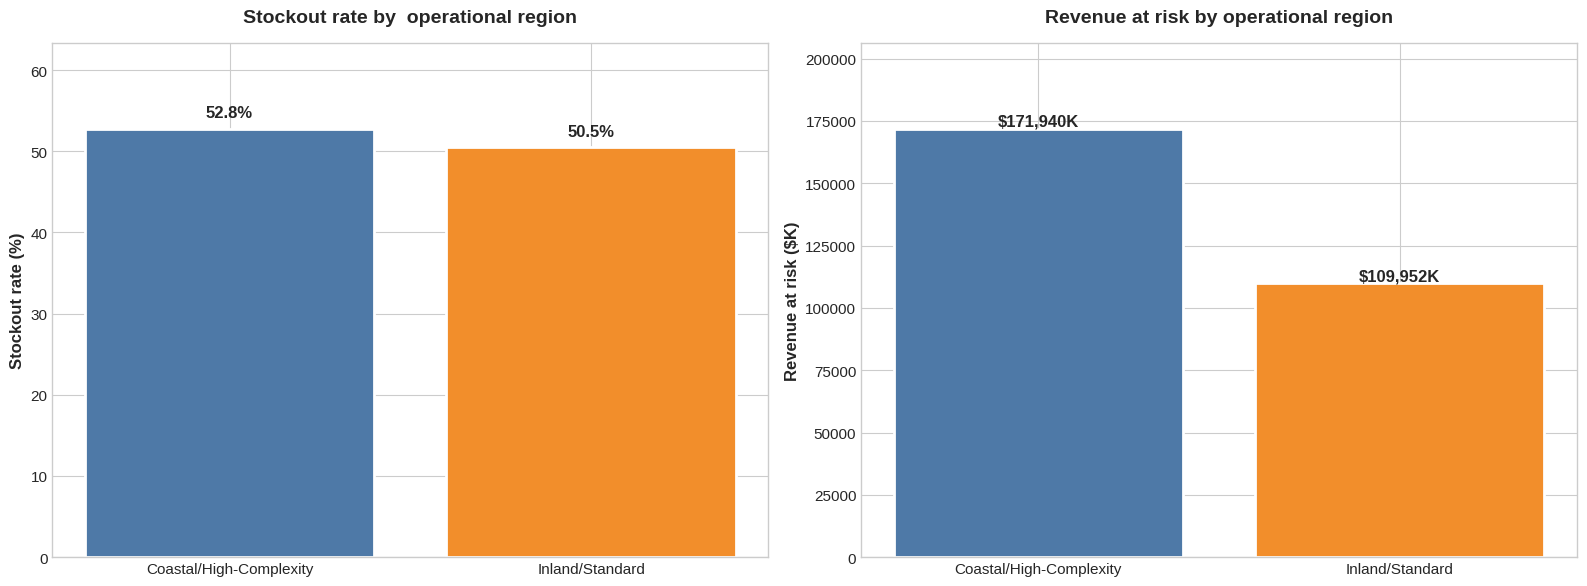

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
stockout_by_region = df.groupby('operational_region').agg({
    'stockout_indicator': ['sum', 'count', 'mean'],
    'revenue_at_risk': 'sum'
}).reset_index()
stockout_by_region.columns = ['Region', 'Stockouts', 'Transactions', 'Stockout_Rate', 'Revenue_Risk']

ax1 = axes[0]
bars1 = ax1.bar(stockout_by_region['Region'],
                stockout_by_region['Stockout_Rate'] * 100,
                color=[COLORS['domestic'], COLORS['international']],
                edgecolor='white', linewidth=2)
ax1.set_ylabel('Stockout rate (%)', fontweight='bold')
ax1.set_title('Stockout rate by  operational region', fontweight='bold', pad=15)
ax1.set_ylim(0, max(stockout_by_region['Stockout_Rate'] * 100) * 1.2)

for bar, rate in zip(bars1, stockout_by_region['Stockout_Rate'] * 100):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)

ax2 = axes[1]
bars2 = ax2.bar(stockout_by_region['Region'],
                stockout_by_region['Revenue_Risk'] / 1000,
                color=[COLORS['domestic'], COLORS['international']],
                edgecolor='white', linewidth=2)
ax2.set_ylabel('Revenue at risk ($K)', fontweight='bold')
ax2.set_title('Revenue at risk by operational region', fontweight='bold', pad=15)
ax2.set_ylim(0, max(stockout_by_region['Revenue_Risk'] / 1000) * 1.2)

for bar, rev in zip(bars2, stockout_by_region['Revenue_Risk'] / 1000):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             f'${rev:,.0f}K', ha='center', va='bottom', fontweight='bold', fontsize=12)
plt.tight_layout()
plt.savefig('visual1_regional_stockout.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()


### 2. Weather impact analysis

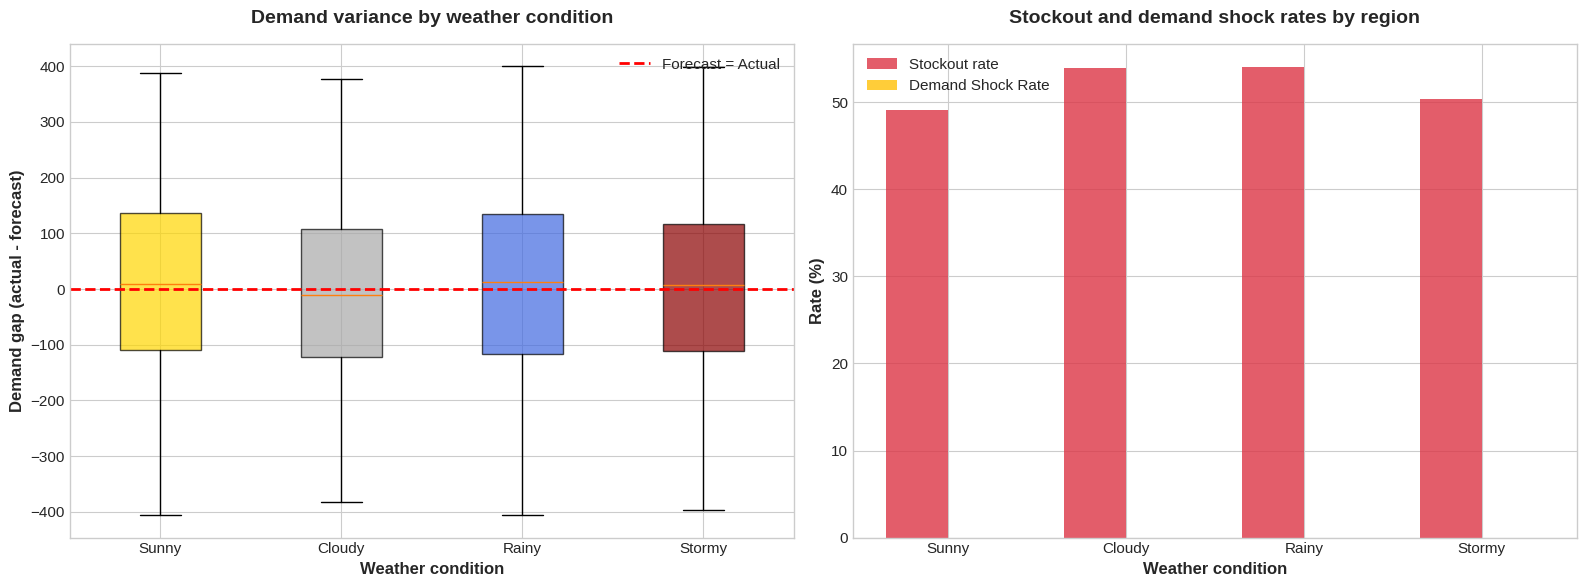

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
ax1 = axes[0]
weather_order = ['Sunny', 'Cloudy', 'Rainy', 'Stormy']
weather_palette = {'Sunny': '#FFD700', 'Cloudy': '#A9A9A9',
                   'Rainy': '#4169E1', 'Stormy': '#8B0000'}

bp_data = [df[df['weather_conditions'] == w]['demand_gap'].values
           for w in weather_order if w in df['weather_conditions'].unique()]
bp_labels = [w for w in weather_order if w in df['weather_conditions'].unique()]

bp = ax1.boxplot(bp_data, labels=bp_labels, patch_artist=True)
for patch, weather in zip(bp['boxes'], bp_labels):
    patch.set_facecolor(weather_palette.get(weather, '#808080'))
    patch.set_alpha(0.7)

ax1.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Forecast = Actual')
ax1.set_ylabel('Demand gap (actual - forecast)', fontweight='bold')
ax1.set_xlabel('Weather condition', fontweight='bold')
ax1.set_title('Demand variance by weather condition', fontweight='bold', pad=15)
ax1.legend(loc='upper right')

# Chart 2B: Stockout rate by weather
ax2 = axes[1]
stockout_by_weather = df.groupby('weather_conditions').agg({
    'stockout_indicator': 'mean',
    'is_demand_shock': 'mean'
}).reset_index()
stockout_by_weather = stockout_by_weather.set_index('weather_conditions').reindex(weather_order).dropna()

x = np.arange(len(stockout_by_weather))
width = 0.35

bars1 = ax2.bar(x - width/2, stockout_by_weather['stockout_indicator'] * 100,
                width, label='Stockout rate', color=COLORS['critical'], alpha=0.8)
bars2 = ax2.bar(x + width/2, stockout_by_weather['is_demand_shock'] * 100,
                width, label='Demand Shock Rate', color=COLORS['warning'], alpha=0.8)

ax2.set_ylabel('Rate (%)', fontweight='bold')
ax2.set_xlabel('Weather condition', fontweight='bold')
ax2.set_title('Stockout and demand shock rates by region', fontweight='bold', pad=15)
ax2.set_xticks(x)
ax2.set_xticklabels(stockout_by_weather.index)
ax2.legend(loc='upper left')

plt.tight_layout()
plt.savefig('visual2_weather_impact.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()


###3. Financial risk heatmap

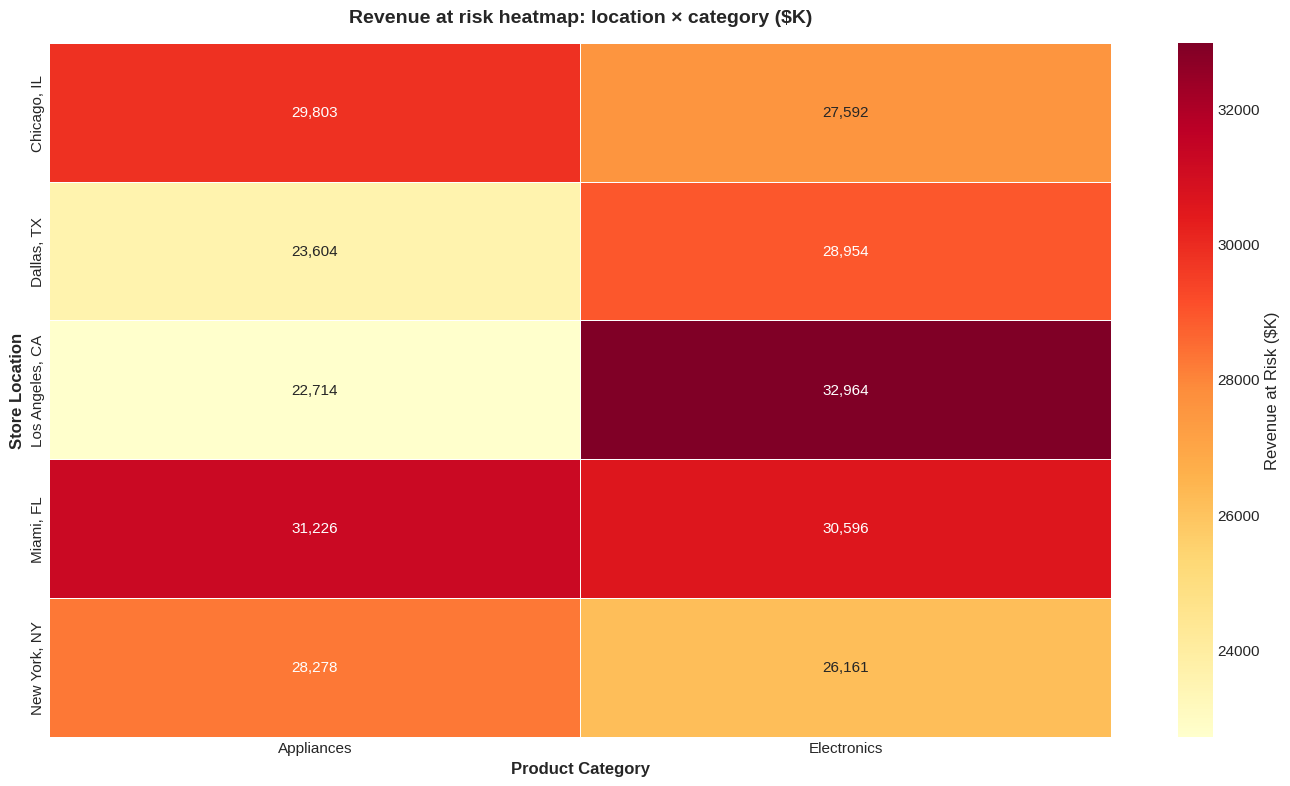

In [81]:
fig, ax = plt.subplots(figsize=(14, 8))
heatmap_data = df.groupby(['store_location', 'category'])['revenue_at_risk'].sum().unstack(fill_value=0)

sns.heatmap(heatmap_data / 1000,
            annot=True, fmt=',.0f', cmap='YlOrRd',
            linewidths=0.5, linecolor='white',
            cbar_kws={'label': 'Revenue at Risk ($K)'},
            ax=ax)

ax.set_title('Revenue at risk heatmap: location × category ($K)',
             fontweight='bold', fontsize=14, pad=15)
ax.set_xlabel('Product Category', fontweight='bold')
ax.set_ylabel('Store Location', fontweight='bold')

plt.tight_layout()
plt.savefig('visual3_risk_heatmap.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

###4. Demand shock distribution

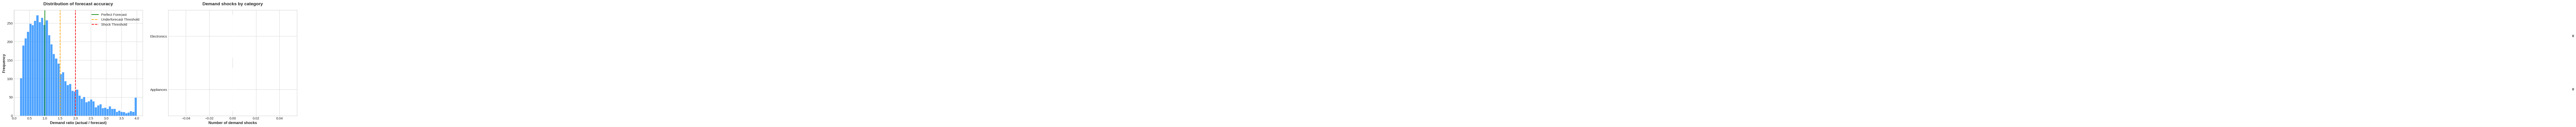

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Chart 4A: Distribution of demand ratio
ax1 = axes[0]
demand_ratios = df['demand_ratio'].dropna()
demand_ratios_clipped = demand_ratios.clip(0, 4)  # Clip for visualization

ax1.hist(demand_ratios_clipped, bins=50, color=COLORS['primary'],
         alpha=0.7, edgecolor='white')
ax1.axvline(x=1.0, color='green', linestyle='-', linewidth=2, label='Perfect Forecast')
ax1.axvline(x=1.5, color='orange', linestyle='--', linewidth=2, label='Underforecast Threshold')
ax1.axvline(x=2.0, color='red', linestyle='--', linewidth=2, label='Shock Threshold')

ax1.set_xlabel('Demand ratio (actual / forecast)', fontweight='bold')
ax1.set_ylabel('Frequency', fontweight='bold')
ax1.set_title('Distribution of forecast accuracy', fontweight='bold', pad=15)
ax1.legend(loc='upper right')

# Chart 4B: demand shocks by category
ax2 = axes[1]
shock_by_category = df.groupby('category').agg({
    'is_demand_shock': ['sum', 'mean']
}).reset_index()
shock_by_category.columns = ['Category', 'Shock_Count', 'Shock_Rate']
shock_by_category = shock_by_category.sort_values('Shock_Count', ascending=True)

colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(shock_by_category)))
bars = ax2.barh(shock_by_category['Category'], shock_by_category['Shock_Count'],
                color=colors, edgecolor='white')

ax2.set_xlabel('Number of demand shocks', fontweight='bold')
ax2.set_title('Demand shocks by category', fontweight='bold', pad=15)

for bar, count in zip(bars, shock_by_category['Shock_Count']):
    ax2.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2,
             f'{count:,.0f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('visual4_demand_shocks.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

###3.5 Time-series trend analysis

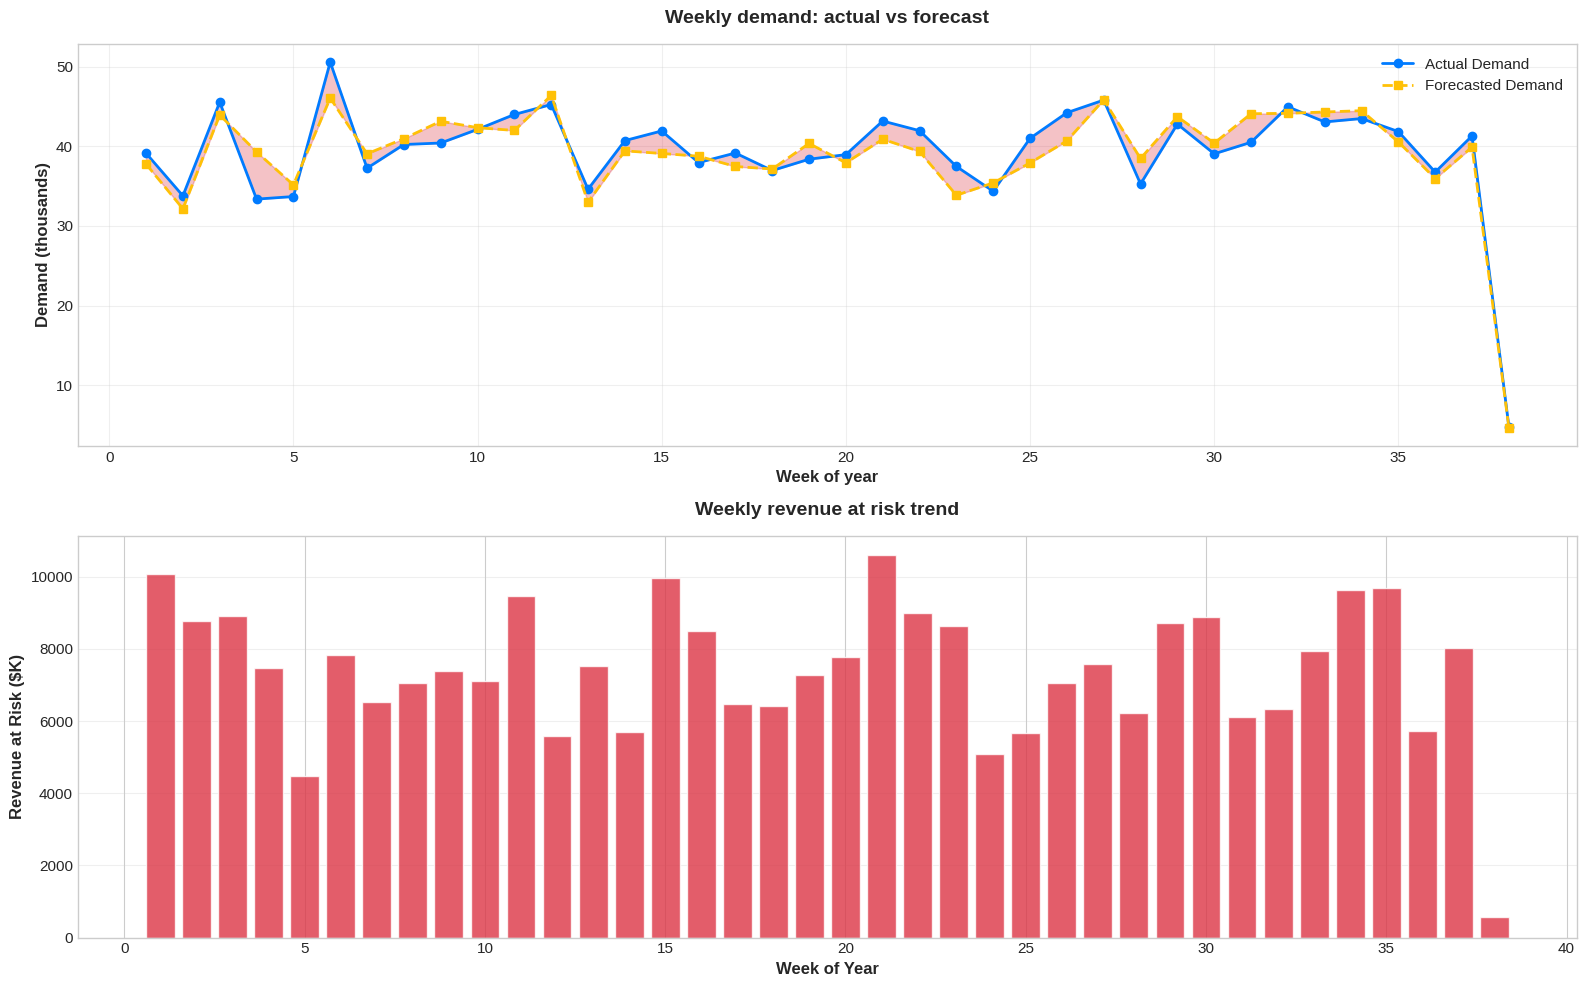

In [91]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
weekly_data = df.groupby('transaction_week').agg({
    'actual_demand': 'sum',
    'forecasted_demand': 'sum',
    'revenue_at_risk': 'sum',
    'stockout_indicator': 'sum'
}).reset_index()

# Chart 5A: actual vs forecast demand
ax1 = axes[0]
ax1.plot(weekly_data['transaction_week'], weekly_data['actual_demand'] / 1000,
         'o-', color=COLORS['primary'], linewidth=2, markersize=6, label='Actual Demand')
ax1.plot(weekly_data['transaction_week'], weekly_data['forecasted_demand'] / 1000,
         's--', color=COLORS['warning'], linewidth=2, markersize=6, label='Forecasted Demand')
ax1.fill_between(weekly_data['transaction_week'],
                 weekly_data['actual_demand'] / 1000,
                 weekly_data['forecasted_demand'] / 1000,
                 alpha=0.3, color=COLORS['critical'])
ax1.set_xlabel('Week of year', fontweight='bold')
ax1.set_ylabel('Demand (thousands)', fontweight='bold')
ax1.set_title('Weekly demand: actual vs forecast', fontweight='bold', pad=15)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Chart 5B: Weekly revenue at risk
ax2 = axes[1]
ax2.bar(weekly_data['transaction_week'], weekly_data['revenue_at_risk'] / 1000,
        color=COLORS['critical'], alpha=0.8, edgecolor='white')
ax2.set_xlabel('Week of Year', fontweight='bold')
ax2.set_ylabel('Revenue at Risk ($K)', fontweight='bold')
ax2.set_title('Weekly revenue at risk trend', fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('visual5_timeseries.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()


### 4. Predictive modelling(Random forest demand prediction)

#### 4.1 Feature preparation

In [92]:
df_model = df.copy()

In [93]:
label_encoders = {}
categorical_features = ['weather_conditions', 'category', 'product_name',
                        'customer_loyalty_level', 'weekday', 'store_location',
                        'operational_region', 'promotion_type']

for col in categorical_features:
    if col in df_model.columns:
        le = LabelEncoder()
        df_model[f'{col}_encoded'] = le.fit_transform(df_model[col].astype(str))
        label_encoders[col] = le

In [94]:
df_model['promotion_encoded'] = df_model['promotion_applied'].astype(int)
df_model['holiday_encoded'] = df_model['holiday_indicator'].astype(int)
df_model['weekend_encoded'] = df_model['is_weekend'].astype(int)

In [95]:
feature_columns = [
    'inventory_level', 'reorder_point', 'reorder_quantity',
    'supplier_lead_time',
    'customer_age', 'customer_income', 'customer_loyalty_level_encoded',
    'unit_price', 'category_encoded', 'product_name_encoded',
    'promotion_encoded', 'holiday_encoded',
    'weather_conditions_encoded',
    'weekday_encoded', 'weekend_encoded', 'transaction_hour',
    'store_location_encoded', 'operational_region_encoded',
    'is_high_complexity', 'coefficient_of_variation'
]


In [96]:
available_features = [col for col in feature_columns if col in df_model.columns]

print(f"\n Model Features ({len(available_features)} total):")
for i, feat in enumerate(available_features, 1):
    print(f"{i:2d}. {feat}")


 Model Features (20 total):
 1. inventory_level
 2. reorder_point
 3. reorder_quantity
 4. supplier_lead_time
 5. customer_age
 6. customer_income
 7. customer_loyalty_level_encoded
 8. unit_price
 9. category_encoded
10. product_name_encoded
11. promotion_encoded
12. holiday_encoded
13. weather_conditions_encoded
14. weekday_encoded
15. weekend_encoded
16. transaction_hour
17. store_location_encoded
18. operational_region_encoded
19. is_high_complexity
20. coefficient_of_variation


In [97]:
X = df_model[available_features].copy()
y = df_model['actual_demand'].copy()

In [98]:
X = X.fillna(X.median())

In [99]:
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

In [100]:
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")


Feature matrix shape: (5000, 20)
Target vector shape: (5000,)


#### 4.2 Train-test split

In [101]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Split ratio: 80/20")


Training set: 4,000 samples
Test set: 1,000 samples
Split ratio: 80/20


#### 4.3 Model training

In [102]:
rf_model = RandomForestRegressor(
    n_estimators=200,           # number of trees
    max_depth=15,               # prevent overfitting
    min_samples_split=10,       # minimum samples to split
    min_samples_leaf=5,         # minimum samples in leaf
    max_features='sqrt',        # feature subsampling
    n_jobs=-1,                  # use all CPU cores
    random_state=42,
    verbose=0
)


In [103]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=10, n_estimators=200, n_jobs=-1,
                      random_state=42)

#### 4.4 Model eval

In [104]:
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

In [105]:
metrics = {
    'Training': {
        'R²': r2_score(y_train, y_train_pred),
        'MAE': mean_absolute_error(y_train, y_train_pred),
        'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred))
    },
    'Test': {
        'R²': r2_score(y_test, y_test_pred),
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred))
    }
}


In [106]:
print(f"""
   Model performance metrics:

   Training set:
   R² Score:  {metrics['Training']['R²']:.4f}
   MAE:       {metrics['Training']['MAE']:.2f} units
   RMSE:      {metrics['Training']['RMSE']:.2f} units

   Test set:
   R² Score:  {metrics['Test']['R²']:.4f}
   MAE:       {metrics['Test']['MAE']:.2f} units
   RMSE:      {metrics['Test']['RMSE']:.2f} units

   Interpretation:
   R² of {metrics['Test']['R²']:.2%} variance explained
   Average prediction error of {metrics['Test']['MAE']:.1f} units
""")


   Model performance metrics:

   Training set:
   R² Score:  0.4219
   MAE:       79.78 units
   RMSE:      92.43 units

   Test set:
   R² Score:  -0.0116
   MAE:       105.58 units
   RMSE:      122.72 units

   Interpretation:
   R² of -1.16% variance explained
   Average prediction error of 105.6 units



#### 4.5 Cross-validation

In [107]:
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2', n_jobs=-1)

print(f"\nCross-val R² scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i}: {score:.4f}")

print(f"\nMean CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")


Cross-val R² scores:
Fold 1: -0.0223
Fold 2: -0.0180
Fold 3: -0.0071
Fold 4: -0.0136
Fold 5: -0.0151

Mean CV R²: -0.0152 (+/- 0.0100)


####4.6 Feature importance analysis

In [108]:
feature_importance = pd.DataFrame({
    'Feature': available_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 15 most important features:")
print("   " + "-" * 50)

for i, (_, row) in enumerate(feature_importance.head(15).iterrows(), 1):
    bar_length = int(row['Importance'] * 50)
    bar = '█' * bar_length
    print(f"   {i:2d}. {row['Feature']:<35} {row['Importance']:.4f} {bar}")


Top 15 most important features:
   --------------------------------------------------
    1. unit_price                          0.1095 █████
    2. customer_income                     0.1026 █████
    3. inventory_level                     0.1003 █████
    4. reorder_quantity                    0.0950 ████
    5. reorder_point                       0.0931 ████
    6. customer_age                        0.0825 ████
    7. transaction_hour                    0.0704 ███
    8. supplier_lead_time                  0.0536 ██
    9. product_name_encoded                0.0498 ██
   10. weekday_encoded                     0.0418 ██
   11. coefficient_of_variation            0.0415 ██
   12. customer_loyalty_level_encoded      0.0323 █
   13. weather_conditions_encoded          0.0318 █
   14. store_location_encoded              0.0259 █
   15. promotion_encoded                   0.0165 


####4.7 Feature importance visualisation

In [109]:
#fig, ax = plt.subplots(figsize=(12, 10))

In [110]:
top_features = feature_importance.head(15).sort_values('Importance', ascending=True)

colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(top_features)))[::-1]
bars = ax.barh(top_features['Feature'], top_features['Importance'],
               color=colors, edgecolor='white', linewidth=1.5)

ax.set_xlabel('Feature Importance', fontweight='bold', fontsize=12)
ax.set_title('Random forest feature importance\nTop 15 demand prediction drivers',
             fontweight='bold', fontsize=14, pad=15)

for bar, imp in zip(bars, top_features['Importance']):
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
            f'{imp:.3f}', va='center', fontweight='bold')

ax.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('visual6_feature_importance.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()


<Figure size 1400x600 with 0 Axes>

####4.8 Key insight -> weather vs price

In [111]:
weather_importance = feature_importance[
    feature_importance['Feature'] == 'weather_conditions_encoded'
]['Importance'].values[0]

price_importance = feature_importance[
    feature_importance['Feature'] == 'unit_price'
]['Importance'].values[0]

print(f"""
   weather importance: {weather_importance:.4f}
   price importance:   {price_importance:.4f}

   verdict: {"WEATHER drives demand more than PRICE" if weather_importance > price_importance
                else "PRICE drives demand more than WEATHER"}

   Strategic implication:
      {"Invest in weather-responsive inventory management" if weather_importance > price_importance
       else "Focus on dynamic pricing strategies"}
      {"Weather forecasting integration is critical" if weather_importance > price_importance
       else "Price elasticity modeling should be prioritized"}
""")


   weather importance: 0.0318
   price importance:   0.1095

   verdict: PRICE drives demand more than WEATHER

   Strategic implication:
      Focus on dynamic pricing strategies
      Price elasticity modeling should be prioritized



In [112]:
df_model['predicted_demand'] = rf_model.predict(X)

### 5. Action deck

#### 5.1 Prepare recommendation engine data

In [113]:
df_final = df.copy()
df_final['predicted_demand'] = df_model['predicted_demand'].values

In [114]:
df_final['supply_gap'] = df_final['predicted_demand'] - df_final['inventory_level']
df_final['projected_stockout'] = df_final['supply_gap'] > 0

In [115]:
action_candidates = df_final[
    (df_final['projected_stockout'] == True) |
    (df_final['stockout_indicator'] == True) |
    (df_final['is_demand_shock'] == True) |
    (df_final['critical_stockout'] == True)
].copy()

print(f"\nAction candidates identified: {len(action_candidates):,} transactions")


Action candidates identified: 4,003 transactions


####5.2 Generate AI recommendations (based on transaction)

In [116]:
def generate_recommendation(row):
    recommendations = []
    priority_score = 0

    # rule 1: critical stockout with long lead time
    if row['critical_stockout'] and row['supplier_lead_time'] > 7:
        recommendations.append("EMERGENCY AIR FREIGHT")
        priority_score += 100

    # rule 2: stockout with bad weather
    if row['stockout_indicator'] and row['weather_conditions'] in ['Stormy', 'Rainy']:
        recommendations.append("Weather-Priority Restock")
        priority_score += 80

    # rule 3: demand shock (underforecast)
    if row['is_demand_shock']:
        units_needed = int(row['supply_gap'])
        recommendations.append(f"Rush Order {units_needed:,} Units")
        priority_score += 70

    # rule 4: high lead time risk
    if row['supplier_lead_time'] > 7 and row['stockout_risk']:
        recommendations.append("Inter-Store Transfer")
        priority_score += 60

    # rule 5: promotion failure (overforecast)
    if row['promotion_applied'] and row['demand_ratio'] < 0.7:
        recommendations.append("Discount 20%")
        priority_score += 40

    # rule 6: standard restock
    if row['stockout_risk'] and not recommendations:
        recommendations.append("STANDARD RESTOCK")
        priority_score += 30

    # default
    if not recommendations:
        recommendations.append("Monitor Closely")
        priority_score += 10

    return recommendations[0], priority_score

# apply recommendation engine
action_candidates['ai_recommendation'], action_candidates['priority_score'] = zip(
    *action_candidates.apply(generate_recommendation, axis=1)
)

####5.3 classify priority levels

In [117]:
def classify_priority(score):
    if score >= 80:
        return 'CRITICAL'
    elif score >= 60:
        return 'HIGH'
    elif score >= 40:
        return 'MEDIUM'
    else:
        return 'LOW'

action_candidates['priority_level'] = action_candidates['priority_score'].apply(classify_priority)

####5.4 calclulate financial impact

In [118]:
action_candidates['financial_impact'] = (
    action_candidates['supply_gap'].clip(lower=0) * action_candidates['unit_price']
)

####5.5 action deck data frame

In [121]:
action_deck = action_candidates[[
    'priority_level', 'priority_score', 'store_location', 'category',
    'product_name', 'weather_conditions', 'inventory_level',
    'predicted_demand', 'supply_gap', 'supplier_lead_time',
    'ai_recommendation', 'financial_impact'
]].copy()

action_deck.columns = [
    'Priority', 'Score', 'Store Location', 'Category',
    'Product', 'Weather', 'Current Inventory',
    'Predicted Demand', 'Supply Gap', 'Lead Time (Days)',
    'AI Recommendation', 'Financial Impact ($)'
]

action_deck = action_deck.sort_values(
    ['Score', 'Financial Impact ($)'],
    ascending=[False, False]
)

print("Consolidating batch orders")

batch_orders = action_deck.groupby(['Store Location', 'Product', 'AI Recommendation']).agg({
    'Predicted Demand': 'sum',
    'Current Inventory': 'sum',
    'Financial Impact ($)': 'sum',
    'Score': 'mean',
    'Priority': 'first',
    'Supply Gap': 'sum',
    'Lead Time (Days)': 'mean',
    'Score': 'count'
}).reset_index()

batch_orders.rename(columns={'Score': 'Order_Count'}, inplace=True)

batch_orders = batch_orders.sort_values('Financial Impact ($)', ascending=False)

display_cols = ['Store Location', 'Product', 'Order_Count',
                'AI Recommendation', 'Financial Impact ($)']

print(f"Compressed {len(action_deck)} individual alerts into {len(batch_orders)} batch orders.")
print("\nTop 10 consolidated batch orders")
display(batch_orders[display_cols].head(10))

Consolidating batch orders
Compressed 4003 individual alerts into 240 batch orders.

Top 10 consolidated batch orders


,Store Location,Product,Order_Count,AI Recommendation,Financial Impact ($)
141,"Los Angeles, CA",Washing Machine,48,Monitor Closely,"5,124,685.91"
190,"Miami, FL",Washing Machine,15,STANDARD RESTOCK,"5,065,776.18"
173,"Miami, FL",Smartphone,37,Weather-Priority Restock,"4,773,346.16"
15,"Chicago, IL",Headphones,43,Monitor Closely,"4,697,598.84"
76,"Dallas, TX",Smartphone,17,STANDARD RESTOCK,"4,439,981.99"
33,"Chicago, IL",TV,50,Monitor Closely,"4,389,131.98"
34,"Chicago, IL",TV,18,STANDARD RESTOCK,"4,351,297.46"
3,"Chicago, IL",Camera,50,Monitor Closely,"4,336,519.94"
177,"Miami, FL",TV,42,Monitor Closely,"4,327,739.95"
87,"Dallas, TX",Tablet,56,Monitor Closely,"4,291,735.66"


####5.6 display

In [124]:
print(f"""

   Total revenue at risk: ${action_deck['Financial Impact ($)'].sum():>25,.2f}
   Active alerts:         {len(action_deck):>25,}
   Critical actions:      {(action_deck['Priority'] == 'CRITICAL').sum():>25,}
""")

print("\nTop 15 priority actions: \n")
print(f"   {'Priority':<12} {'Location':<18} {'Category':<12} {'Product':<15} "
      f"{'Weather':<10} {'Inventory':<10} {'Gap':<8} {'Lead Time':<10} "
      f"{'Recommendation':<25} {'Impact ($)':<12}")
print("   " + "-" * 130)

for i, (_, row) in enumerate(action_deck.head(15).iterrows(), 1):
    print(f"   {row['Priority']:<12} {str(row['Store Location'])[:16]:<18} "
          f"{str(row['Category'])[:10]:<12} {str(row['Product'])[:13]:<15} "
          f"{str(row['Weather'])[:8]:<10} {row['Current Inventory']:>8,.0f}  "
          f"{row['Supply Gap']:>6,.0f}  {row['Lead Time (Days)']:>8.0f}d   "
          f"{str(row['AI Recommendation'])[:23]:<25} ${row['Financial Impact ($)']:>10,.0f}")

print("   " + "=" * 130)



   Total revenue at risk: $           455,713,567.29
   Active alerts:                             4,003
   Critical actions:                          1,394


Top 15 priority actions: 

   Priority     Location           Category     Product         Weather    Inventory  Gap      Lead Time  Recommendation            Impact ($)  
   ----------------------------------------------------------------------------------------------------------------------------------
   CRITICAL     Los Angeles, CA    Electronic   Smartphone      Rainy            13     284        10d   EMERGENCY AIR FREIGHT     $   437,374
   CRITICAL     Chicago, IL        Appliances   Tablet          Rainy            10     250         8d   EMERGENCY AIR FREIGHT     $   394,355
   CRITICAL     Los Angeles, CA    Electronic   TV              Stormy           16     275        10d   EMERGENCY AIR FREIGHT     $   314,333
   CRITICAL     Los Angeles, CA    Electronic   TV              Stormy           11     284         8d  

####5.7 urgent actions summary

In [125]:
urgent_actions = action_deck[action_deck['Priority'] == 'CRITICAL'].head(5)

print("Critical actions (top 5) ")


for i, (_, row) in enumerate(urgent_actions.iterrows(), 1):
    print(f"{i}. {row['Store Location']:<15} | {row['Category']:<12}| {row['Product']:<15}")
    print(f"Weather: {row['Weather']:<10}| Lead Time: {row['Lead Time (Days)']:.0f} days")
    print(f"AI: {row['AI Recommendation']:<25}")
    print(f"Impact: ${row['Financial Impact ($)']:,.0f}")


Critical actions (top 5) 
1. Los Angeles, CA | Electronics | Smartphone     
Weather: Rainy     | Lead Time: 10 days
AI: EMERGENCY AIR FREIGHT    
Impact: $437,374
2. Chicago, IL     | Appliances  | Tablet         
Weather: Rainy     | Lead Time: 8 days
AI: EMERGENCY AIR FREIGHT    
Impact: $394,355
3. Los Angeles, CA | Electronics | TV             
Weather: Stormy    | Lead Time: 10 days
AI: EMERGENCY AIR FREIGHT    
Impact: $314,333
4. Los Angeles, CA | Electronics | TV             
Weather: Stormy    | Lead Time: 8 days
AI: EMERGENCY AIR FREIGHT    
Impact: $311,386
5. Chicago, IL     | Electronics | Washing Machine
Weather: Stormy    | Lead Time: 9 days
AI: EMERGENCY AIR FREIGHT    
Impact: $64,057


####5.8 action distribution summary

In [126]:
# by recommendation type
rec_summary = action_deck.groupby('AI Recommendation').agg({
    'Financial Impact ($)': ['count', 'sum']
}).reset_index()
rec_summary.columns = ['Recommendation', 'Count', 'Total Impact ($)']
rec_summary = rec_summary.sort_values('Total Impact ($)', ascending=False)

print("\nActions by recommendation type:\n")
for _, row in rec_summary.iterrows():
    print(f"   • {row['Recommendation']:<25}: {row['Count']:>5,} actions | "
          f"${row['Total Impact ($)']:>12,.0f}")


Actions by recommendation type:

   • Monitor Closely          : 1,750 actions | $ 139,005,879
   • STANDARD RESTOCK         :   436 actions | $ 112,324,400
   • Weather-Priority Restock : 1,244 actions | $ 111,544,703
   • EMERGENCY AIR FREIGHT    :   133 actions | $  36,041,167
   • Discount 20%             :   339 actions | $  33,520,823
   • Inter-Store Transfer     :   101 actions | $  23,276,595


In [127]:
#by location
loc_summary = action_deck.groupby('Store Location').agg({
    'Financial Impact ($)': ['count', 'sum']
}).reset_index()
loc_summary.columns = ['Location', 'Count', 'Total Impact ($)']
loc_summary = loc_summary.sort_values('Total Impact ($)', ascending=False)

print("\nActions by store location:\n")
for _, row in loc_summary.iterrows():
    print(f"   • {row['Location']:<20}: {row['Count']:>5,} actions | "
          f"${row['Total Impact ($)']:>12,.0f}")


Actions by store location:

   • Chicago, IL         :   826 actions | $  95,529,160
   • Dallas, TX          :   796 actions | $  93,602,054
   • Los Angeles, CA     :   828 actions | $  92,645,296
   • Miami, FL           :   761 actions | $  92,131,620
   • New York, NY        :   792 actions | $  81,805,437


####5.9 export actions

In [128]:
action_deck.to_csv('walmart_sccc_action_deck.csv', index=False)
df_anomalies.to_csv('walmart_sccc_anomaly_watchlist.csv', index=False)
df_final.to_csv('walmart_sccc_enriched_data.csv', index=False)


##EXTRA

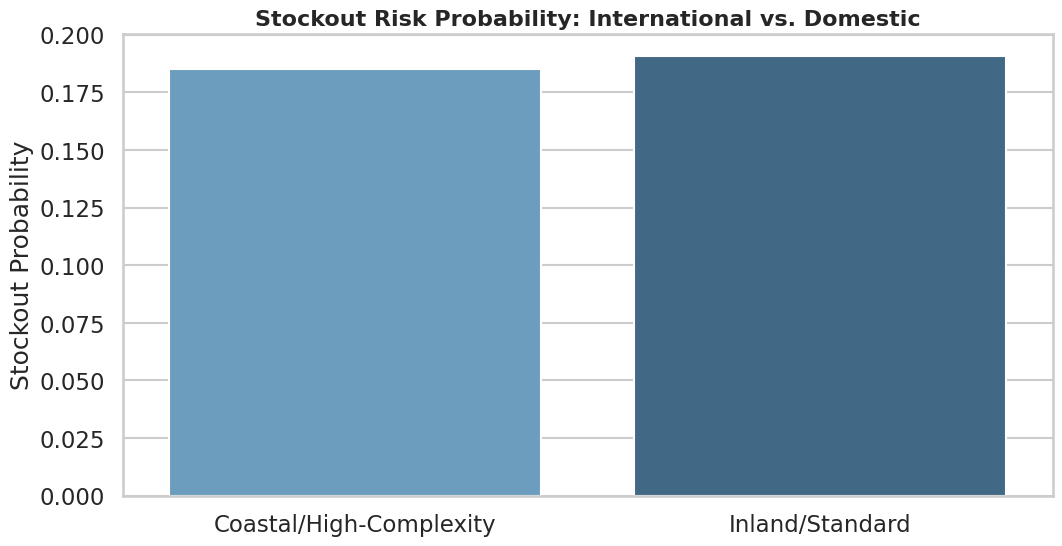

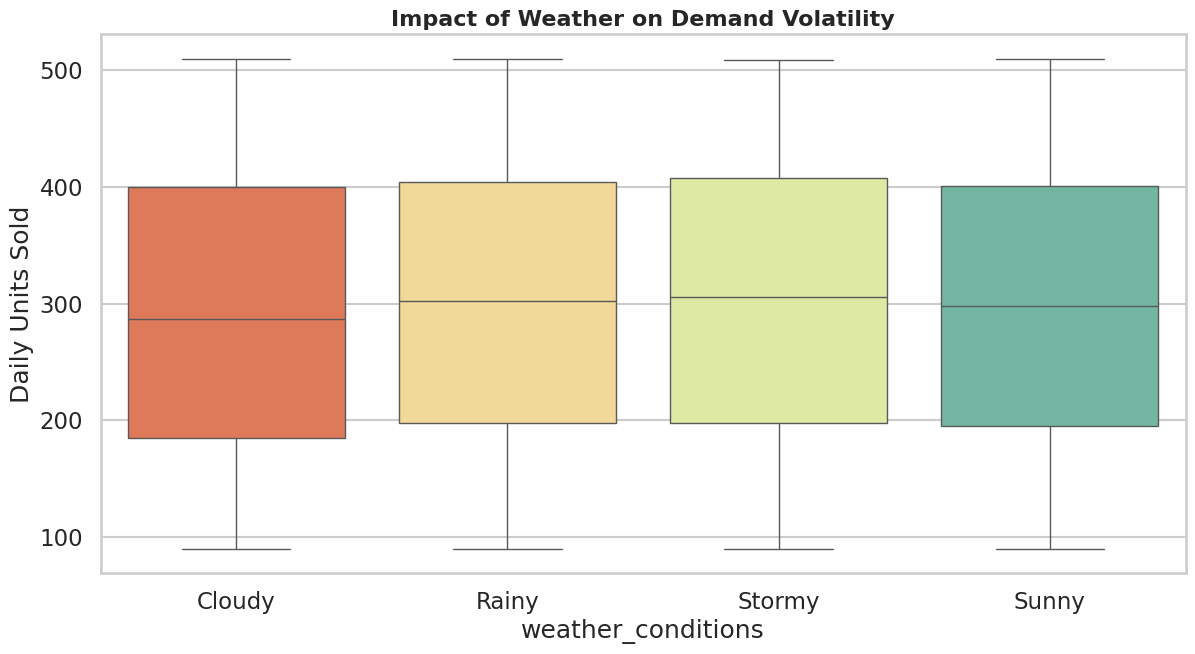

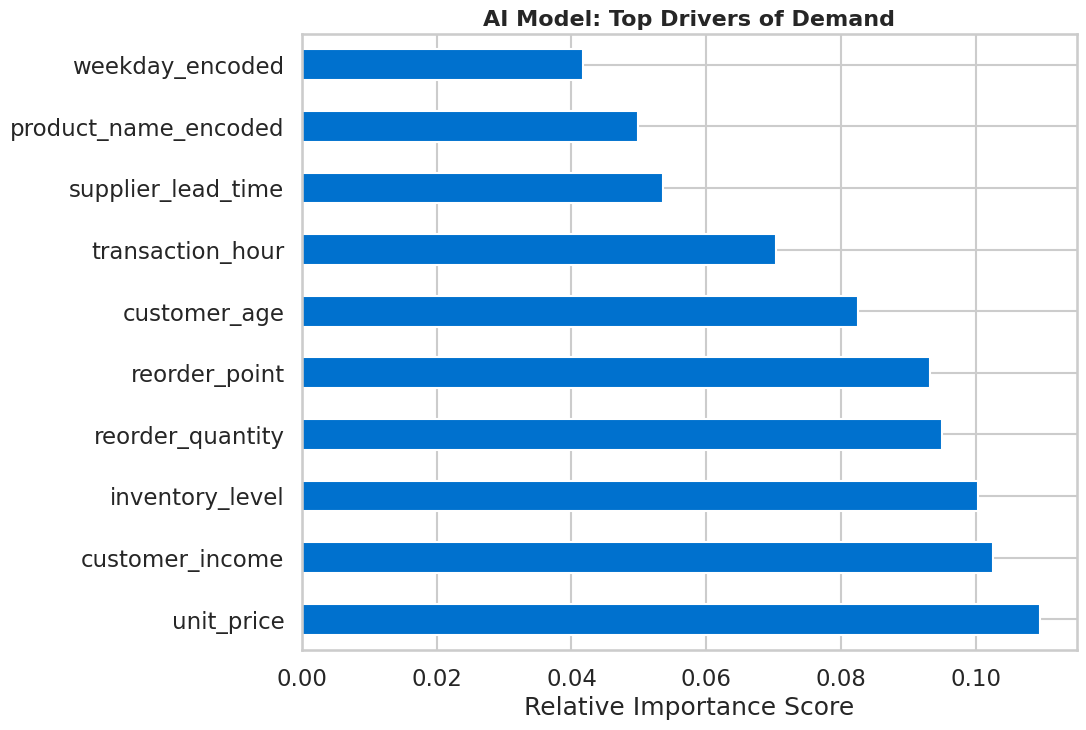

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('default')
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

# global stockout risk
plt.figure(figsize=(12, 6))
sns.barplot(x='operational_region', y='stockout_risk', data=df, palette='Blues_d', errorbar=None)
plt.title('Stockout Risk Probability: International vs. Domestic', fontsize=16, fontweight='bold')
plt.ylabel('Stockout Probability')
plt.xlabel('')
plt.savefig('visual1_regional_stockout.png', bbox_inches='tight', dpi=300)
plt.show()

# weather impact boxplot
plt.figure(figsize=(14, 7))
sns.boxplot(x='weather_conditions', y='actual_demand', data=df, palette='Spectral')
plt.title('Impact of Weather on Demand Volatility', fontsize=16, fontweight='bold')
plt.ylabel('Daily Units Sold')
plt.savefig('visual2_weather_impact.png', bbox_inches='tight', dpi=300)
plt.show()

# feature importance from model
if 'rf_model' in globals():
    plt.figure(figsize=(10, 8))
    feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
    feat_importances.nlargest(10).plot(kind='barh', color='#0071ce') # Walmart Blue
    plt.title('AI Model: Top Drivers of Demand', fontsize=16, fontweight='bold')
    plt.xlabel('Relative Importance Score')
    plt.savefig('visual3_feature_importance.png', bbox_inches='tight', dpi=300)
    plt.show()


In [130]:
# Debug FI
if 'rf_model' in globals():
    import pandas as pd
    feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
    print("\nModel Drivers:")
    print(feat_importances.sort_values(ascending=False))


Model Drivers:
unit_price                       0.11
customer_income                  0.10
inventory_level                  0.10
reorder_quantity                 0.10
reorder_point                    0.09
customer_age                     0.08
transaction_hour                 0.07
supplier_lead_time               0.05
product_name_encoded             0.05
weekday_encoded                  0.04
coefficient_of_variation         0.04
customer_loyalty_level_encoded   0.03
weather_conditions_encoded       0.03
store_location_encoded           0.03
promotion_encoded                0.02
holiday_encoded                  0.02
category_encoded                 0.01
weekend_encoded                  0.01
operational_region_encoded       0.01
is_high_complexity               0.01
dtype: float64


In [131]:
source_dir = os.getcwd()
target_dir = '/content/drive/MyDrive/DM project'

csv_files = [
    'walmart_sccc_action_deck.csv',
    'walmart_sccc_anomaly_watchlist.csv',
    'walmart_sccc_enriched_data.csv'
]

image_files = [
    'visual1_regional_stockout.png',
    'visual2_weather_impact.png',
    'visual3_risk_heatmap.png',
    'visual4_demand_shocks.png',
    'visual5_timeseries.png',
    'visual6_feature_importance.png'
]

print(f"Source directory: {source_dir}")
print(f"Target directory: {target_dir}")
print(f"CSV files to be processed: {csv_files}")
print(f"Image files to be processed: {image_files}")

Source directory: /content
Target directory: /content/drive/MyDrive/DM project
CSV files to be processed: ['walmart_sccc_action_deck.csv', 'walmart_sccc_anomaly_watchlist.csv', 'walmart_sccc_enriched_data.csv']
Image files to be processed: ['visual1_regional_stockout.png', 'visual2_weather_impact.png', 'visual3_risk_heatmap.png', 'visual4_demand_shocks.png', 'visual5_timeseries.png', 'visual6_feature_importance.png']


In [132]:
import shutil

for csv_file in csv_files:
    shutil.copy(os.path.join(source_dir, csv_file), os.path.join(target_dir, csv_file))
    print(f"Copied {csv_file} to {target_dir}")

for image_file in image_files:
    shutil.copy(os.path.join(source_dir, image_file), os.path.join(target_dir, image_file))
    print(f"Copied {image_file} to {target_dir}")

Copied walmart_sccc_action_deck.csv to /content/drive/MyDrive/DM project
Copied walmart_sccc_anomaly_watchlist.csv to /content/drive/MyDrive/DM project
Copied walmart_sccc_enriched_data.csv to /content/drive/MyDrive/DM project
Copied visual1_regional_stockout.png to /content/drive/MyDrive/DM project
Copied visual2_weather_impact.png to /content/drive/MyDrive/DM project
Copied visual3_risk_heatmap.png to /content/drive/MyDrive/DM project
Copied visual4_demand_shocks.png to /content/drive/MyDrive/DM project
Copied visual5_timeseries.png to /content/drive/MyDrive/DM project
Copied visual6_feature_importance.png to /content/drive/MyDrive/DM project
